In [ ]:
# importing the libraries
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# Load Dataset
data = pd.read_csv('/content/IMDB Dataset.csv')
data.head(3)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive


In [ ]:
# Rows and Columns
data.shape

(50000, 2)

In [ ]:
# # Sample the Dataset
# df = data.groupby('sentiment').sample(n=1500, random_state=42)
# df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# # Value Counts
# df['sentiment'].value_counts()

In [ ]:
df = data
data['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


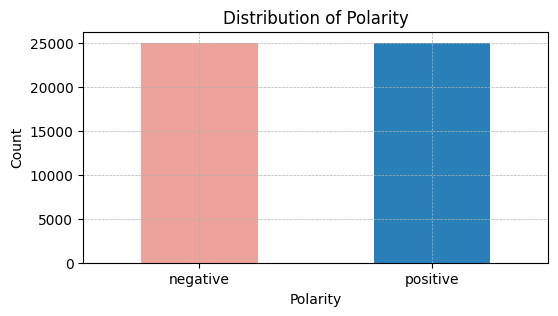

In [ ]:
# Plot Distribution of Sentiment Polarity
plt.figure(figsize=(6, 3))
df['sentiment'].value_counts().sort_index().plot(kind='bar', color=['#eba39c', '#2980b9'])
plt.title('Distribution of Polarity')
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.xticks(rotation=0)  # horizontal labels
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
# Check Missing Values
df.isnull().sum()

,0
review,0
sentiment,0


In [ ]:
import re

# Define Text Cleaning Function
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # remove special characters
    text = re.sub(r'\s+', ' ', text)  # remove extra whitespaces
    text = text.strip()  # remove leading and trailing spaces
    return text.lower()  # convert to lowercase

# Apply Text Ceaning
df['review_cleaned'] = df['review'].apply(clean_text)

# Label Encoding
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
df.sample(3)

,review,sentiment,review_cleaned
36368,"Great cast, great acting, great music. Each ch...",1,great cast great acting great music each chara...
27873,This movie should not be viewed unless you are...,0,this movie should not be viewed unless you are...
42244,A realistic depiction of young love for the co...,1,a realistic depiction of young love for the co...


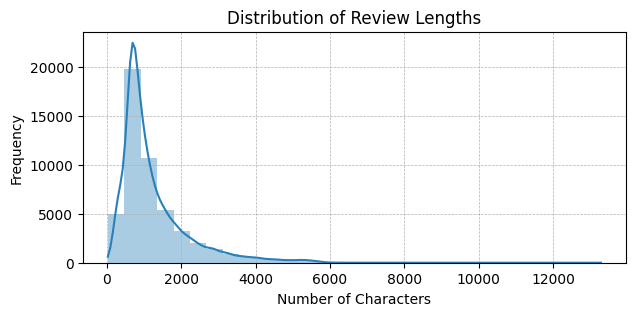

In [ ]:
# Count Review Length
df['review_length'] = df['review_cleaned'].apply(len)

# Distribution of Review Lengths
plt.figure(figsize=(7, 3))
sns.histplot(df['review_length'], bins=30, kde=True, color='#2980b9', edgecolor=None, alpha=0.4)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
df['review_length'].describe()

,review_length
count,50000.000000
mean,1243.709180
std,940.802063
min,30.000000
25%,666.000000
50%,922.000000
75%,1508.000000
max,13286.000000


In [ ]:
# # Sample the Dataset
# df = data.groupby('sentiment').sample(n=1500, random_state=42)
# df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# # Value Counts
# df['sentiment'].value_counts()

In [ ]:
texts = df['review_cleaned'].tolist()
labels = df['sentiment']

In [ ]:
# Dataset class for text classification
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        # Convert labels to a list to avoid index issues
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        # Returns the number of samples in the dataset
        return len(self.texts)

    def __getitem__(self, idx):
        # Fetches the sample at the given index
        text = self.texts[idx]
        label = self.labels[idx]
        # Tokenizes the text and converts it into input IDs and attention mask
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length,
                                   padding='max_length', truncation=True)
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label)
        }

In [ ]:
# BERT-based classifier for text classification
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        # Load the pre-trained BERT model
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)  # Dropout for regularization
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)  # Fully connected layer for classification

    def forward(self, input_ids, attention_mask):
        # Forward pass through the BERT model
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # Use the pooled output for classification
        x = self.dropout(pooled_output)  # Apply dropout
        logits = self.fc(x)  # Pass through the fully connected layer
        return logits

In [ ]:
# Function to train the model
def train(model, data_loader, optimizer, scheduler, device):
    model.train()  # Set the model to training mode
    for batch in data_loader:
        optimizer.zero_grad()  # Clear the gradients
        # Move data to the specified device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        # Compute loss
        loss = nn.CrossEntropyLoss()(outputs, labels)
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        scheduler.step()

In [ ]:
# Function to evaluate the model
def evaluate(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            # Move data to the specified device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)  # Get predicted labels
            # Collect predictions and actual labels
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    # Compute accuracy and classification report
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)


In [ ]:
# Function to predict sentiment of a single text
def predict_sentiment(text, model, tokenizer, device, max_length=128):
    model.eval()  # Set the model to evaluation mode
    # Tokenize and encode the input text
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length,
                         padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)  # Get the predicted label
    return "positive" if preds.item() == 1 else "negative"


In [ ]:
# Set up parameters
bert_model_name = 'bert-base-uncased'  # Name of the pre-trained BERT model
num_classes = 2  # Number of output classes (e.g., positive/negative sentiment)
max_length = 128  # Maximum token length for input sequences
batch_size = 16  # Batch size for training and evaluation
num_epochs = 4  # Number of training epochs
learning_rate = 2e-5  # Learning rate for the optimizer

In [ ]:
# Split data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels,
                                                                    test_size=0.2, random_state=42)


In [ ]:
# Tokenize and create datasets and data loaders
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)


In [ ]:
# Set up the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize the model, optimizer, and scheduler
model = BERTClassifier(bert_model_name, num_classes).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


In [ ]:
# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train(model, train_dataloader, optimizer, scheduler, device)  # Train the model
    accuracy, report = evaluate(model, val_dataloader, device)  # Evaluate on validation set
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(report)

Epoch 1/4
Validation Accuracy: 0.9031
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      4961
           1       0.91      0.90      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Epoch 2/4
Validation Accuracy: 0.8990
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4961
           1       0.93      0.87      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Epoch 3/4
Validation Accuracy: 0.9019
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      4961
           1       0.90      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg  

In [ ]:
# Test sentiment prediction on a new text
test_text = "The company reported a significant increase in profits this quarter, thanks to strong demand for their new product line"
sentiment = predict_sentiment(test_text, model, tokenizer, device)
print(test_text)
print(f"Predicted sentiment: {sentiment}")

The company reported a significant increase in profits this quarter, thanks to strong demand for their new product line
Predicted sentiment: positive


In [ ]:
# Test sentiment prediction
test_text = "The stock market took a sharp downturn today, with major indices falling due to fears of an economic recession."
sentiment = predict_sentiment(test_text, model, tokenizer, device)
print("The stock market took a sharp downturn today, with major indices falling due to fears of an economic recession.")
print(f"Predicted sentiment: {sentiment}")

The stock market took a sharp downturn today, with major indices falling due to fears of an economic recession.
Predicted sentiment: positive


In [ ]:
import torch

# Save model state_dict
torch.save(model.state_dict(), "bert_sentiment_model.pth")

# Save tokenizer
tokenizer.save_pretrained("bert_tokenizer")


('bert_tokenizer/tokenizer_config.json',
 'bert_tokenizer/special_tokens_map.json',
 'bert_tokenizer/vocab.txt',
 'bert_tokenizer/added_tokens.json')

In [ ]:
import torch
from transformers import BertTokenizer
from torch import nn
from transformers import BertModel

class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained("bert_tokenizer")

# Define model with same architecture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model_name = 'bert-base-uncased'
num_classes = 2

loaded_model = BERTClassifier(bert_model_name, num_classes).to(device)

# Load the saved model weights
loaded_model.load_state_dict(torch.load("bert_sentiment_model.pth", map_location=device))
loaded_model.eval()


<ipython-input-96-9b99e4725443>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load("bert_sentiment_model.pth", map_location=device))


BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
def predict_sentiment(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
    return "positive" if preds.item() == 1 else "negative"

# Test prediction with loaded model
test_text = "The product is absolutely amazing and exceeded my expectations!"
sentiment = predict_sentiment(test_text, loaded_model, tokenizer, device)
print(f"Predicted sentiment: {sentiment}")


Predicted sentiment: positive
